# Understanding the p-median problem: the gateway to spatial optimisation

*Levi John Wolf* [levi.john.wolf@bristol.ac.uk](mailto:levi.john.wolf@bristol.ac.uk)

## Tell: background and concepts for p-median problems

In the previous notebook, we worked with a general-purpose *mathematical* programming problem, the *knapsack problem*, which seeks to maximise the benefit gained from "packing" a set of objects such that all objects fit into the knapsack. We use binary decision variables $x_i$ to represent whether or not an item is taken (with $i=1...n$). Items each have some benefit $b_i$ and size $s_i$; our knapsack has a total size of $c$, past which we cannot pack any more items in. With these symbols, we state the *knapsack problem* as: 

<div class="alert alert-success" role="alert">
<b>The Knapsack Problem </b>


*Maximize:* 

$\sum_i^n b_ix_i$

*Subject To:*

1. *Size constraint:*&emsp; $\sum_i^n s_i x_i \leq c$
2. *Binary decisions:*&emsp; $x_i \in {0,1} \ \ \forall \ \ i = 1, 2, ..., n$

</div>

Spatial optimisation problems get slightly more complex than this, both in terms of the numbers and the types of constraints. 

## The unique challenge of spatial optimisation

Generally, any *spatial* optimisation problem requires us to use a *spatial decision variable* to represent the spatial *locations of* or *relation between* decisions we take. Often, *relation* decisions are either *allocation* or *routing* decisions, which will be explained in detail below. Spatial optimisation can be quite challenging because the number of decisions we have to make about spatial *relations* will balloon rapidly as the problem size gets larger.

Recall that the knapsack problem is an *aspatial* optimisation problem: items are either "packed" or they're "not packed." This "packed"/"not packed" decision variable is similar to a *locational* decision variable. When we are are trying to determine which site is the best to *locate* a facility, we use one binary *locational decision variable* for each item being located: is site A chosen for a facility or not? Note that this means there is no information about the *relation* of items in the knapsack or locations being sited to one another. We don't use a decision variable that indicates we would prefer to pack pencils *more than* packing pens, or locate at site A *instead of* site B, for example. This preference is implicit in the final set of decisions: do we pack pens *and* pencils, or just pack *pencils*? 

Many *other* kinds of spatial optimisation problems do require *relational decision variables* that represent decisions we make that relate two things. A very common example of a relational decision variable is an *allocation* variable that tracks whether we *allocate* an object to a given class. For example, an "allocation" decision in a knapsack example might be needed if you were trying to figure out whether to take chewing gum *in your backpack* or *in your pocket*. The "location-style" decision variable is "do I pack chewing gum?", and the "allocation-style" decision is that "do I pack the chewing gum in my pocket or in my backpack?" In fact, many spatial optimisation problems are *location-allocation* problems like this, where locational decisions about "do we locate a facility at site A?" are paired with *allocation* decisions: does the facility at site A serve client 1? Often, we intend to *allocate* some larger number of things (clients, items to take to school) to a smaller number of things (facilities, backpack or pocket). This *location-allocation* framework covers many of the most important problems in spatial optimisation. 

Another kind of *spatial* optimisation problems involves *routing* decisions. These are sometimes relatively easy, like solving for the [*shortest path*](https://en.wikipedia.org/wiki/Shortest_path_problem) from one location to another. But, other kinds of problems, like trying to find an optimal [*delivery route*](https://en.wikipedia.org/wiki/Travelling_salesman_problem), are quite difficult. In both of these problems, the *spatial decision variable* involves a choice about whether or not a *link* between two *waypoints* is selected or not. Similar to an *allocation* variable, the decision variable about the *route* is a binary variable for *each pair of waypoints*: do we go from site A to site B? 

While this sounds simple, the number of decisions being made grows quickly for *allocation* and *routing* problems. Generally, problems that involve only *location* decisions are the smallest and easier to solve, followed by those that involve *allocation*, and finally those that involve *routing*. And, *location* problems are already among the class of hardest computational problems to solve to optimality, so "easier" does not mean "easy"! Problems are made more complex when decisions are *contingent upon* other decisions, hence a *location-allocation* problem will be harder to solve generally than an *allocation* problem where the location decisions are already made. Problems that entail all three (location-allocation-routing) are quite difficult to solve indeed. 

Let us think about a concrete example to make this clearer. Imagine we have 8 delivery trucks split across 4 possible depot sites. But, we only have the funding to operate *two* depots. Each truck should start and end its delivery route in its depot. Over the course of the day, we need to deliver to 5,000 housing units in total. In this case, we can illustrate the three typical kinds of *spatial* decision variables as the following: 

1. *locating depots*: do we locate a depot at site $i$? This is often just a binary decision variable, $x_i$, for each possible depot site. Thus, it represents $4$ decision variables.
2. *allocating trucks to depots*: does truck $j$ get allocated to depot $i$? This is a small matrix of decision variables, $\mathbf{Y}$, with one $z_{ij}$ for each $i,j$ pair representing whether truck $j$ will be allocated to depot $i$. It represents $8 * 4$ decision variables. 
3. *allocating houses to trucks*: does house $k$ get allocated to truck $j$? This is a matrix of decision variables $\mathbf{Z}$, with one $Z_{jk}$ for each $j,k$ pair representing whether truck $j$ will be allocated to deliver to house $k$. It represents $8 * 5,000$ decision variables overall. 
4. *routing trucks*: what route does truck $j$ take to serve its allocated houses $k$? Classically, this is represented by a $k \times k$ matrix for *each* $j$, $\mathbf{R}_j$, that records whether the link between $k_1$ and $k_2$ is selected for the route. This results in $k^2$ decision variables *per truck*, which (optimistically, when all routes have the same size) is just over $3,000,000$ decision variables for all trucks! 

Thus, you can see how a simple problem like parcel delivery gets very large, very quickly. We will cover decisions 1 and 3 to discuss an introductory spatial optimisation problem. 

 ## Introducing classical location-allocation: the P-Median problem

The $p$-Median problem is the challenge of locating some set number ($p$) of "medians" so that they minimise the distance to a set of sites we're trying to service. For our purposes, we will also refer to the medians as "facilities" and the sites we're trying to service as "clients," to match the `spopt` package's terms. Sometimes, facilities can be located anywhere (in the "continuous P-Median" model). In our case, we will focus on cases where medians can only occupy fixed locations, the "discrete P-Median" model, which is more common in planning and site selection tasks. 

In this case, we have a collection of decisions to make. First, we make a locational decision: do we open a facility at site $j$? If we have $m$ possible sites for facilities, this can be represented with $m$ decision variables ($y_j$). Then, we need to *allocate* clients to open facilities. If we have $n$ clients, this requires us to build a "client-to-facility" matrix ($\mathbf{Z}$)of shape $n \times m$ to record the allocation decisions for each client to each facility, $z_{ij}$. Note that this allocation decision of site $i$ to facility $j$ is *contingent upon* the location decision at $j$: we cannot assign any clients to a "closed" facility ($y_j = 0$)! 

Finally, we need to model how "good" our problem solution is. Generally in median problems, we define the "cost" of an allocation to represent the effort required to satisfy the allocation: we consider the *distance* between each client and facility pair and *how much* has to be carried over that distance. This generally represents the "work" you do for that allocation decision, and is flexible enough to accommodate nonlinear functions of distance (e.g. increasing costs to travel with a squared distance or decreasing costs to travel with a logarithmic distance). For the clasical $p$-Median problem, we represent our "work" as the distance ($d_{ij}$) between facilities and their allocated clients *times* the amount of stuff we're carrying from facilty to client ($w_i$). But, we will *only* carry something from facility $j$ to client $i$ *if* we make an allocation decision $z_{ij}$. Thus, for all client-facility pairs, we want to minimise the sum of the weighted distances between clients and assigned facilities: 

$$ d_{11}z_{11}w_{1} + d_{12}z_{12}w_{1} + ... + d_{1m}z_{1m}w_{1} + d_{21}z_{21}w_2 + d_{22}z_{22}w_2 + ... + d_{nm}z_{nm}w_{n} = \sum_i^n\sum_j^m d_{ij}z_{ij}w_i$$

Thus, when client $i$ is assigned to facility $j$ ($z_{ij}=1$), we get $d_{ij}*1*w_i=d_{ij}w_i$, distance times load size. But, when client $i$ is *not* assigned to facility $j$, $z_{ij} = 0$, so $d_{ij}*0*w_i=0$. This is how we represent the sum of distances between clients and their allocated facility, the *objective* of the p-median model. 

To complete the model, we need to make sure that (1) only $p$ facilities are located and (2) every client is allocated to one open facility. For (1), we can use something like our size constraint from the knapsack problem: 

$$ \sum_{j}^{m} y_{j} = p$$

This *constraint* ensures that exactly $p$ facilities are located, since the sum of $y_i$ represents the number of facilities opened. For (2), we have to make sure that every client is assigned to one (and only one) facility. So, we have to write a constraint for *each client* to ensure it gets assigned to one facility. 
$$ \sum_{j}^{m} z_{ij} = 1$$

Thus, we will have $n$ constraints that ensure that clients are assigned to exactly one open facility. But, note that this constraint *does not* ensure that we allocate client $i$ to an _open_ facility $j$: $z_{ij}$ could be 1 while $y_j$ could be zero! Thus, we need an *allocation* constraint linking $z$ and $y$, to ensure that no client can be assigned to a closed facility. This requires a constraint on *each decision variable* $z_{ij}$ that ensures $z_{ij}$ can only be $1$ if $y_j$ is one: 

$$ z_{ij} \leq y_j $$

Thus, the siutation we describe above where a client is assigned to a closed facility (in math, $z_{ij} = 1$ when $y_{j} = 0$) can never happen *so long as* this constraint is used. 

Together, these comprise the P-Median problem: 

<div class="alert alert-success" role="alert">
<b>The P Median Problem</b>

*Minimise* 

$\sum_i^n\sum_j^m d_{ij}z_{ij}w_{i}$

*Subject To:*

1. *Locate $p$ Facilities*:&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp; $ \sum_{j}^{m} y_{j} = p$
2. *Allocate Clients Once*:&emsp;&emsp;&emsp; $ \sum_{j}^{m} z_{ij} = 1 \ \ \ \ \forall i$
3. *Allocate to Open Facilities*:&emsp; $ z_{ij} \leq y_j \ \ \ \ \forall i,j$
4. *Binary Location Decisions*:&emsp; $y_j \in {0,1} \ \ \ \ \forall j$ <br>&emsp;&emsp;&emsp;&emsp;&ensp;&emsp;&emsp;&emsp;&emsp;&ensp;&emsp;&emsp;&emsp;&emsp;   $z_{ij} \in {0,1} \ \ \ \ \forall i,j$

</div>

You can see that this problem requires some information about the relationships between clients and facilities, $d_{ij}$, in order to *solve* for the values of decision variables $z_{ij}$ and $y_j$. Thus, we will walk you through how to set up this problem for yourself using the `spopt` package, along with a few other geospatial packages. 

Also a few caveats are in order. First, when the weight of each demand is constant, we can ignore $w_i$ in our formulation and solve a simpler *unweighted $p$-Median model*. However, this is rarely the case, so we'll consider the typical *weighted $p$-Median model*. Also, note that if we allocate client $i$ to facility $j$, we're committing to serving *all of* the demand client $i$ has using facility $j$; no other facility is allowed to help. If we relax this and allow for multiple facilities to help out with serving demand $i$, this is known as a *fractional allocation* $p$-Median model. This is encountered occasionally, but can be challenging to explain and investigate the results, so we will keep to the total allocation version. 

## Show: learn how to specify a p-median problem

For this example, we will solve for parcel depots in inner-city Bristol. We will use a few more libraries this time: 

In [ ]:
import pandas
import pulp
import geopandas # standard library for geographical data in Python
import numpy # standard library for numerical and array-based computing
import spopt # library for spatial optimisation

To implement a $p$-Median problem, we will start with data on the location of postcodes in the UK: 

In [ ]:
postcodes = pandas.read_csv("./uk_postcodes.csv")
postcodes.head()

Further, since we have geographic data (in terms of the latitude and longitude of postcode centroids), we will use `geopandas` to make maps and work with the spatial data. 

In [ ]:
postcodes = geopandas.GeoDataFrame(
    postcodes, 
    geometry=geopandas.points_from_xy(postcodes.lon, postcodes.lat, crs="epsg:4326")
)

To keep the analysis tractable, we will also focus *only* on inner-city Bristol postcodes: 

In [ ]:
bristol_postcodes = postcodes[postcodes.outward.str.startswith("BS")].copy()

# is the postcode in the center of the city? 
is_inner_city = bristol_postcodes.outward.str.lstrip("BS").astype(int) < 10

# if so, keep it around
bristol_innercity = bristol_postcodes[is_inner_city].copy()

To visualise, this results in only nine postcodes in the center of the city: 

In [ ]:
bristol_innercity

In [ ]:
bristol_innercity.explore('demand', cmap='Reds', tiles='CartoDb positron', marker_kwds=dict(radius=8))

In this case, we will assume that we are locating facilities at postcode centroids, and all client demand exists at that centroid. This is obviously an abstraction, but many real-world companies solve their location-allocation problems at exactly this level of abstraction! 
 
To build a `PMedian` object, we use the `PMedian()` class from the `spopt.locate` module: 

In [ ]:
model = spopt.locate.PMedian.from_geodataframe(
    gdf_demand=bristol_innercity,
    gdf_fac=bristol_innercity,
    demand_col="geometry", 
    facility_col="geometry",
    weights_cols="demand",
    p_facilities=2
)

This object is a special instance of the `spopt` spatial optimisation library for Python's `locate` class, which supports generic location-allocation problem specifications: 

In [ ]:
model

You can see that the underlying `pulp` model is stored in the `.problem` attribute, and it should look similar to the problem we specified above. But, it will be *rather long* because of the number of constraints: 

In [ ]:
model.problem

Even in a "small" problem with eight facilities, we have 91 constraints. 

To solve the model, we use the `.solve()` method (like before in the knapsack problem), but `spopt` requires you to specify the solver you want to use directly. This is because `spopt`'s default problem size is quite large, compared to the default solver that `pulp` encourages you to use: COIN-OR. This ensures that users do not accidentally run *very* long (i.e. many-day) computations that can crash your computer; in order to solve, you have to explicitly specify your solver, preventing accidental solving runs. 

We will use the open-source COIN-OR solver here, `pulp.COIN_CMD()`. This also allows you to provide options to the solver itself, such as `msg=False`, which turns off the verbose printing of model progress: 

In [ ]:
model.solve(pulp.GUROBI(msg=False))

For the solved `PMedian` object, the `.cli2fac` list records the facility that each client was assigned to in the optimal solution. You can see this below:  

In [ ]:
model.cli2fac

The `spopt` package stores this in a list-of-lists form because for *fractional assignment* problems, observation 1 might be assigned to *both* `7` and `5`. For now, though, every client in the `.cli2fac` list should only be assigned to a single facility, and you can see this is the case above. 

In addition, the mapping *in reverse* is stored in the `.fac2cli` list-of-lists: 

In [ ]:
model.fac2cli

Generally, we will want to *stack* the list-of-lists in `.cli2fac` into a single column that corresponds to the row indices in our input client dataframe. I recommend using `numpy.stack()` to do this: 

In [ ]:
numpy.stack(model.cli2fac).squeeze()

<div class="alert alert-success">
<b>Digression</b>

More experienced Pythonistas may ask why I use `numpy.stack()` instead of something else like `numpy.hstack()`. If you are interested, the reason is that [`numpy.hstack` combines badly with undesirable behavior caused by rounding in the `.solve()` method.](https://github.com/pysal/spopt/issues/364) It is safer to use `numpy.stack()` so that you can identify if there are erroneous allocations arising from these rounding issues.  

</div>

Let's store these allocations to a vector, `allocations`:

In [ ]:
allocations = numpy.stack(model.cli2fac)

I find it easier to work with *names*, rather than *locations* in a dataframe, so I will grab the *postcode* for each allocation:

In [ ]:
allocation_by_name = bristol_innercity.outward.values[allocations]

Now, to visualize our result, we can add the column back to our input dataframe. Note that `pandas` prefers our input to be a "flat" array, rather than a column vector, so we can use the `.flatten()` method: 

In [ ]:
bristol_innercity['allocation_by_name'] = allocation_by_name.flatten()
bristol_innercity.sort_values("allocation_by_name")

Like before in our knapsack problem, we can see the decision variables that are constructed by `spopt`. They are usually stored directly in the object, ending in `vars`. So, for instance, the facility *location* decision variables, $y_i$, are stored in `.fac_vars`:

In [ ]:
model.fac_vars

You can work with them directly like we did in the knapsack notebook, using `.varValue` to get the optimal value of that decision variable (for instance): 

In [ ]:
bristol_innercity.assign(
    selected_for_depot = [dv.varValue for dv in model.fac_vars]
).sort_values("selected_for_depot")

You can also see the whole matrix of assignment variables, $z_{ij}$, in `cli_assgn_vars`: 

In [ ]:
model.cli_assgn_vars

If you want to interact with *these* decision variables, you have to loop over the matrix to extract each $z_{ij}$. Generally, this won't be necessary unless you are working with a *fractional assignment* $p$-Median problem, but it is useful to know this regardless: 

In [ ]:
n_clients, n_facilities = model.cli_assgn_vars.shape

allocation_matrix = numpy.empty_like(model.cli_assgn_vars, dtype=int)

for client in range(n_clients):
    for facility in range(n_facilities):
        allocation_matrix[client,facility] = int(model.cli_assgn_vars[client,facility].varValue)

In [ ]:
allocation_matrix

Finally, the distances $d_{ij}$ (sometimes stored altogether in a *cost matrix* $\mathbf{D}$), are contained in the `.aij` attribute: 

In [ ]:
model.aij.round(2)

By default, `spopt` implements euclidean distance between clients and facilities. But, you can use your own distance metric by passing a `metric` argument (like, `metric='manhattan'`). Alternatively, you can use the much more flexible `PMedian.from_cost_matrix()` function to form a P-Median problem directly from *your own* distance matrix. 

Finally, the underlying `pulp` mathematical program can be accessed as `model.problem`. This means that any component of the underlying model can be modified or accessed. For instance, the actual "objective" function from the model can still be accessed at `model.problem.objective`:

In [ ]:
model.problem.objective

And, given that we have solved the problem, we can access the objective *value*, which measures how good our solution is, through the objective's `.value()` method: 

In [ ]:
model.problem.objective.value()

## Do: apply p-median techniques for yourself

Now it is time for you to try your hand at solving $p$-Median problems. 

## One again, with feeling

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create a new PMedian problem object to locate eight depots across all Bristol post codes? Are BS6 and BS8 chosen again in this new setup? It may help to make a map using the `.explore()` method. 

</div>

In [ ]:
bristol_postcodes = postcodes[postcodes.outward.str.startswith("BS")].copy()

In [ ]:
bristol_postcodes.head(3)

In [ ]:
bristol_postcodes.explore('demand', cmap='viridis', tiles='CartoDb positron', marker_kwds=dict(radius=8))

In [ ]:
model_do1 = spopt.locate.PMedian.from_geodataframe(
    gdf_demand=bristol_postcodes,
    gdf_fac=bristol_postcodes,
    demand_col="geometry", 
    facility_col="geometry",
    weights_cols="demand",
    p_facilities=8
)

In [ ]:
model_do1

In [ ]:
model_do1.problem

In [ ]:
model_do1.solve(pulp.GUROBI(msg=False))

In [ ]:
model_do1.cli2fac

In [ ]:
model_do1.fac2cli

In [ ]:
numpy.stack(model_do1.cli2fac).squeeze()

In [ ]:
allocations_do1 = numpy.stack(model_do1.cli2fac)

In [ ]:
allocation_by_name_do1 = bristol_postcodes.outward.values[allocations_do1]

In [ ]:
bristol_postcodes['allocation_by_name'] = allocation_by_name_do1.flatten()
bristol_postcodes.sort_values("allocation_by_name")

In [ ]:
bristol_postcodes.assign(
    selected_for_depot = [dv.varValue for dv in model_do1.fac_vars]
).sort_values("selected_for_depot")

In [ ]:
model_do1.problem.objective.value()

In [ ]:
bristol_postcodes.explore('allocation_by_name', cmap='tab20', tiles='CartoDb positron', marker_kwds=dict(radius=8))

## Keep the old solutions around

Unfortunately, between us discovering the first solution for inner-city postcodes and your new work looking at a *all* of Bristol, the depots in BS6 and BS8 were already built. Thus, we need to re-solve the problem for all of Bristol while *ensuring that* BS6 and BS8 are in the solution. We support this in `spopt` using a `predefined_facilities_col` argument. This column should contain `True` when an observation is *must* be selected for the solution, and `False` when it may is allowed to be omitted from the solution. 

In our case, build the column:

```python
bristol_postcodes['preselected'] = bristol_postcodes.outward.isin(("BS6", "BS8"))
```

and use that as the `predefined_facilities_col` argument in `spopt`.

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create a new PMedian problem object to locate eight depots across all Bristol post codes, so that *BS6* and *BS8* are required to be selected as depots? how do the assigments differ between this case and your previous Bristol-wide solution? Which solution is better? It may help to make a map using the `.explore()` method or examine the models' objective values. 

</div>

In [193]:
bristol_postcodes2 = postcodes[postcodes.outward.str.startswith("BS")].copy()
bristol_postcodes2['preselected'] = bristol_postcodes2.outward.isin(("BS6", "BS8"))

In [ ]:
bristol_postcodes2.head(3)

In [194]:
bristol_postcodes2.explore('demand', cmap='viridis', tiles='CartoDb positron', marker_kwds=dict(radius=8))

In [195]:
model_do2 = spopt.locate.PMedian.from_geodataframe(
    gdf_demand=bristol_postcodes2,
    gdf_fac=bristol_postcodes2,
    demand_col="geometry", 
    facility_col="geometry",
    weights_cols="demand",
    predefined_facility_col="preselected",
    p_facilities=8
)

In [196]:
model_do2

In [197]:
model_do2.problem

p-median:
MINIMIZE
47.30031854782245*z_0_10_ + 1.0361187166119716*z_0_11_ + 17.64451089286123*z_0_12_ + 30.070698643944432*z_0_13_ + 33.67067815815623*z_0_14_ + 49.22505775125753*z_0_15_ + 43.93592469194352*z_0_16_ + 32.54972776682061*z_0_17_ + 37.249959435137036*z_0_18_ + 18.00862731852615*z_0_19_ + 11.602046150529919*z_0_1_ + 39.48949655052043*z_0_20_ + 38.14645714581941*z_0_21_ + 5.854280146562571*z_0_22_ + 17.5591774549161*z_0_23_ + 12.85869744092999*z_0_24_ + 24.496384063648627*z_0_25_ + 15.338440857538139*z_0_26_ + 22.39478090774675*z_0_27_ + 14.82518872785912*z_0_28_ + 22.84730309788942*z_0_29_ + 8.687418499052596*z_0_2_ + 14.15898186940736*z_0_30_ + 5.369300697314089*z_0_31_ + 17.286416803889832*z_0_32_ + 8.658586042982929*z_0_33_ + 3.15234800420545*z_0_34_ + 17.00498056822232*z_0_35_ + 28.84020352406507*z_0_36_ + 4.513015497867477*z_0_37_ + 5.291105242473352*z_0_38_ + 7.513845620280466*z_0_39_ + 4.562291591125745*z_0_3_ + 25.78792059395443*z_0_40_ + 3.29945044727688*z_0_41_ + 

In [198]:
model_do2.solve(pulp.GUROBI(msg=False))

In [ ]:
model_do2.cli2fac

In [ ]:
model_do2.fac2cli

In [199]:
numpy.stack(model_do2.cli2fac).squeeze()

array([41, 38, 41, 38, 41, 30, 23, 23, 38, 30, 10, 41, 35, 14, 14, 14, 14,
       14, 14, 35, 14, 14, 41, 23, 30, 27, 27, 27, 23, 23, 30, 38, 35, 41,
       41, 35, 14, 38, 38, 38, 23, 41, 41])

In [200]:
allocations_do2 = numpy.stack(model_do2.cli2fac)

In [201]:
allocation_by_name_do2 = bristol_postcodes2.outward.values[allocations_do2]

In [203]:
# bristol_postcodes2['allocation_by_name'] = allocation_by_name_do2.flatten()
bristol_postcodes2['allocation_original'] = allocation_by_name_do1.flatten()
bristol_postcodes2.sort_values("allocation_by_name")

,outward,easting,northing,lat,lon,demand,geometry,preselected,allocation_by_name,allocation_original
274,BS19,386545,172250,51.449072,-2.194994,153.784619,POINT (-2.19499 51.44907),False,BS19,BS19
285,BS29,338633,159454,51.330858,-2.882200,69.199398,POINT (-2.88220 51.33086),False,BS22,BS22
300,BS49,343064,165272,51.383623,-2.819535,88.332075,POINT (-2.81954 51.38362),False,BS22,BS22
284,BS28,342956,147513,51.223947,-2.818243,51.635750,POINT (-2.81824 51.22395),False,BS22,BS22
282,BS26,340944,154549,51.287001,-2.848220,132.225273,POINT (-2.84822 51.28700),False,BS22,BS22
281,BS25,342603,158612,51.323699,-2.825086,59.861844,POINT (-2.82509 51.32370),False,BS22,BS22
279,BS23,331094,162635,51.358590,-2.991015,68.551554,POINT (-2.99101 51.35859),False,BS22,BS24
278,BS22,340962,161426,51.348838,-2.849098,168.622250,POINT (-2.84910 51.34884),False,BS22,BS22
277,BS21,341501,171539,51.439815,-2.843036,93.591290,POINT (-2.84304 51.43982),False,BS22,BS22
280,BS24,335265,158208,51.319278,-2.930309,164.565053,POINT (-2.93031 51.31928),False,BS22,BS24


In [ ]:
bristol_postcodes2.assign(
    selected_for_depot = [dv.varValue for dv in model_do2.fac_vars]
).sort_values("selected_for_depot")

In [ ]:
model_do2.problem.objective.value()

In [ ]:
bristol_postcodes2.explore('allocation_by_name', cmap='tab20', tiles='CartoDb positron', marker_kwds=dict(radius=8))

In [ ]:
bristol_postcodes.explore('allocation_by_name', cmap='tab20', tiles='CartoDb positron', marker_kwds=dict(radius=8))

In [204]:
bristol_postcodes2["same_alloc"] = bristol_postcodes2['allocation_by_name'] == bristol_postcodes2['allocation_original']

In [206]:
bristol_postcodes2.explore('same_alloc', cmap='tab20', tiles='CartoDb positron', marker_kwds=dict(radius=8))

## Locate depots outside of the city

Land is too expensive in the city. Now, the supervisor wants to make sure that *no* facilities are selected in the city. One way to do this is to use all of the postcodes in *outer Bristol* as facilities, but keep all of the postcodes as demands. To get the postcodes for outer bristol, we invert the selection from inner Bristol:

```python
# in pandas, ~ inverts True/False statements
bristol_outercity = bristol_postcodes[~ is_inner_city].copy()
```

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create a new PMedian problem object to locate eight depots in *outer Bristol* that service *all postcodes in Bristol*? How do the assigments differ between this case and your previous Bristol-wide solution? It may help to make a map using the `.explore()` method. 

</div>

In [ ]:
bristol_postcodes = postcodes[postcodes.outward.str.startswith("BS")].copy()

bristol_outercity = bristol_postcodes[~ is_inner_city].copy()

In [ ]:
bristol_outercity.head(3)

In [ ]:
bristol_outercity.explore('demand', cmap='viridis', tiles='CartoDb positron', marker_kwds=dict(radius=8))

In [ ]:
model_do3 = spopt.locate.PMedian.from_geodataframe(
    gdf_demand=bristol_postcodes,
    gdf_fac=bristol_outercity,
    demand_col="geometry", 
    facility_col="geometry",
    weights_cols="demand",
    p_facilities=8
)

In [ ]:
model_do3

In [ ]:
model_do3.problem

In [ ]:
model_do3.solve(pulp.GUROBI(msg=False))

In [ ]:
numpy.stack(model_do3.cli2fac).squeeze()

In [ ]:
allocations_do3 = numpy.stack(model_do3.cli2fac)

In [ ]:
len(allocation_by_name_do3)

In [ ]:
allocation_by_name_do3 = bristol_postcodes.outward.values[allocations_do3]

In [ ]:
bristol_postcodes['allocation_by_name'] = allocation_by_name_do3.flatten()
bristol_postcodes.sort_values("allocation_by_name")

In [ ]:
bristol_outercity.assign(
    selected_for_depot = [dv.varValue for dv in model_do3.fac_vars]
).sort_values("selected_for_depot")

In [ ]:
model_do3.problem.objective.value()

In [ ]:
bristol_postcodes.explore('allocation_by_name', cmap='tab20', tiles='CartoDb positron', marker_kwds=dict(radius=8))

## **Challenge**: Where to stop? 

It is often confusing to figure out how many facilities are *actually needed* to satisfy a given demand. Estimates of the number of depots can vary, and more is not always better: there is often a [diminishing return](https://en.wikipedia.org/wiki/Diminishing_returns) (or at least a plateau) past which additional depots are less helpful in serving demand points. So: 

<div class="alert alert-warning">
    
Using the methods we discussed above, can you create and solve a few new PMedian problems in order to locate 1, 2, 3, ..., 20 depots. Make a plot of the objective function value for each problem. With this information in mind, how many depots do you need before each "extra" depot starts having a fairly weak impact? How many depots would you suggest locating if it costs "20" units to open a depot? 
</div>

In [176]:


def get_obj_value(fac_num, df):
    bristol_postcodes2 = df.copy()
    model_do2 = spopt.locate.PMedian.from_geodataframe(
        gdf_demand=bristol_postcodes2,
        gdf_fac=bristol_postcodes2,
        demand_col="geometry", 
        facility_col="geometry",
        weights_cols="demand",
        p_facilities=fac_num
    )
    model_do2.solve(pulp.GUROBI(msg=False))

    numpy.stack(model_do2.cli2fac).squeeze()
    allocations_do2 = numpy.stack(model_do2.cli2fac)
    allocation_by_name_do2 = bristol_postcodes2.outward.values[allocations_do2]
    bristol_postcodes2['allocation_by_name'] = allocation_by_name_do2.flatten()
    bristol_postcodes2 = bristol_postcodes2.assign(
        selected_for_depot = [dv.varValue for dv in model_do2.fac_vars]
    ).sort_values("selected_for_depot")
    obj_val = model_do2.problem.objective.value()
    return obj_val, bristol_postcodes2

In [177]:
bristol_postcodes3 = postcodes[postcodes.outward.str.startswith("BS")].copy()

In [178]:
a, b = get_obj_value(8, bristol_postcodes3)

In [179]:
a

175.77023190257393

In [187]:
obs = []

for i in range(1, 20+1):
    a, b = get_obj_value(i, bristol_postcodes3)
    obs.append({"obj_val": a, "num_fac": i})

In [191]:
import pandas as pd

obs_df = pd.DataFrame(obs)

obs_df["accum_cost"] = obs_df["num_fac"] * 20

<Axes: xlabel='num_fac', ylabel='obj_val'>

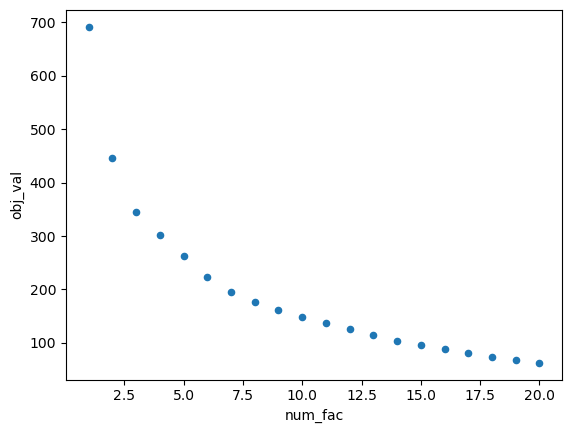

In [190]:
obs_df.plot.scatter("num_fac", "obj_val")

In [207]:
obs_df["total_cost"] = obs_df["accum_cost"] + obs_df["obj_val"]

<Axes: >

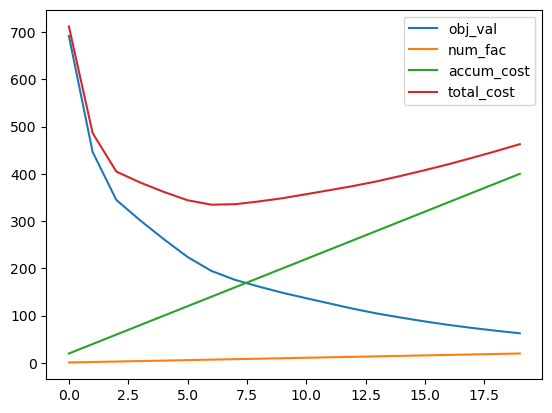

In [208]:
obs_df.plot()

In [210]:
obs_df.sort_values("total_cost")

,obj_val,num_fac,accum_cost,total_cost
6,194.786221,7,140,334.786221
7,175.770232,8,160,335.770232
8,161.571710,9,180,341.571710
5,224.170830,6,120,344.170830
9,148.428125,10,200,348.428125
10,136.944905,11,220,356.944905
4,261.780113,5,100,361.780113
11,125.638472,12,240,365.638472
12,114.423560,13,260,374.423560
3,301.762890,4,80,381.762890


## Review

$p$-Median problems are a kind of *spatial optimisation* problem that occurs when trying to locate $p$ facilities and allocate $n$ clients points to these facilities. It requires both *location* decisions (where to place facilities) and *allocation* decisions (what client is served by what facility). As such, is it considered a fundamental *location-allocation* problem, and has structures common to many different kinds of spatial optimisation problems, such as the transportation problem or the warehouse location problem. Many different customisations can be implemented *on top* of the $p$-Median problem, such as the *unweighted*, *continuous*, *capacitated*, or *fractional allocation* problems. Regardless, the $p$-Median problem can be stated and solved easily in Python using the `spopt` library, which wraps the large amount of constraint and variable declarations required to build the $p$-Median model in the underlying `pulp` package. It supports many variants of the $p$-Median problem, including cases where the client sites are not the same as the facility sites and the use of travel time/routing distances.  